In [1]:
import sys
sys.path.insert(0,"..")
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch, gc
from torch.utils.data import SubsetRandomSampler
import torch.optim as optim


from unet.model import UNet 
from unet.training import Trainer as UNet_trainer

from gan.discriminator import Discriminator
from gan.training import Trainer as gan_trainer

from mwcnn.mwcnn import MWCNN
from mwcnn.training import Trainer as mwcnn_trainer

from src.loss_functions import FFTloss, VGGPerceptualLoss
from src.dataset import ImageDataset
from src.utils import get_indices, plot_loss, psnr, plot_result

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Dataset part used for testing
VALIDATION_SPLIT = 0.15
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 5
# Full Dataset path
TEST_DATASETS = ['val']
TRAIN_DATASETS = ['train']
ROOTDIR = '../data/'

# Training Epochs
EPOCHS = 400

IMAGESIZE = 256

gc.collect()
torch.cuda.empty_cache()

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may hav

In [2]:
train_image_dataset = ImageDataset(ROOTDIR, TRAIN_DATASETS, normalize="percentile", image_size=IMAGESIZE)
train_indices, validation_indices = get_indices(len(train_image_dataset), train_image_dataset.root_dir, VALIDATION_SPLIT, new=True)
train_sampler, validation_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(validation_indices)

trainloader = torch.utils.data.DataLoader(train_image_dataset, BATCH_SIZE, sampler=train_sampler)
validationloader = torch.utils.data.DataLoader(train_image_dataset, BATCH_SIZE, sampler=validation_sampler)

test_image_dataset = ImageDataset(ROOTDIR, TEST_DATASETS, normalize="percentile", image_size=IMAGESIZE)
testloader = torch.utils.data.DataLoader(test_image_dataset, 1)

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


## Pretrain UNET
First pretrain a UNET and MWCNN, afterwards, this can be used in the GAN set-up

In [5]:
filter_num = [16,32,64,128,256]
unet_model = UNet(filter_num).to(device)
# Training
unet_trainer = UNet_trainer(unet_model,device)
unet_train_loss_record, unet_validation_loss_record = unet_trainer.train(EPOCHS,trainloader,validationloader,mini_batch=100)

MODEL_NAME = f"../models/UNet-{filter_num}.pth"
torch.save(unet_model, MODEL_NAME)

print(f'Training finished!')

Starting Training Process
Epoch: 001,  
 Training Loss:0.0169518,  
  Validation Loss:0.0130392,  
  Epoch: 002,  
 Training Loss:0.0133828,  
  Validation Loss:0.0156988,  
  Epoch: 003,  
 Training Loss:0.0133669,  
  Validation Loss:0.0130039,  
  Epoch: 004,  
 Training Loss:0.0131644,  
  Validation Loss:0.0131220,  
  Epoch: 005,  
 Training Loss:0.0135449,  
  Validation Loss:0.0139700,  
  Epoch: 006,  
 Training Loss:0.0117255,  
  Validation Loss:0.0110367,  
  Epoch: 007,  
 Training Loss:0.0110421,  
  Validation Loss:0.0119259,  
  Epoch: 008,  
 Training Loss:0.0103580,  
  Validation Loss:0.0111870,  
  Epoch: 009,  
 Training Loss:0.0097949,  
  Validation Loss:0.0094904,  
  Epoch: 010,  
 Training Loss:0.0087643,  
  Validation Loss:0.0102657,  
  Epoch: 011,  
 Training Loss:0.0086039,  
  Validation Loss:0.0083179,  
  Epoch: 012,  
 Training Loss:0.0081274,  
  Validation Loss:0.0093498,  
  Epoch: 013,  
 Training Loss:0.0078190,  
  Validation Loss:0.0085639,  
 

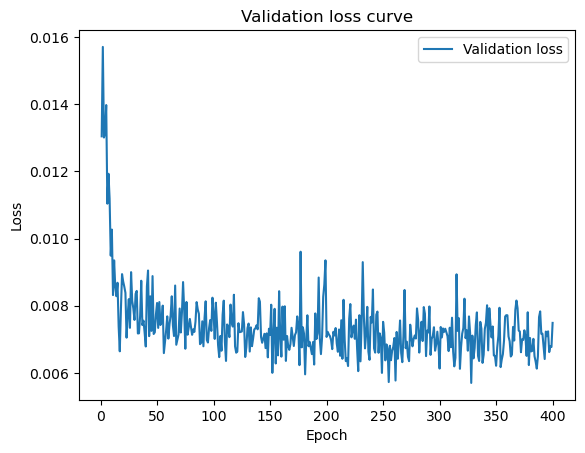

In [6]:
plot_loss(EPOCHS, unet_validation_loss_record, title="Validation loss curve", label="Validation loss")

## Train GAN with UNET


In [7]:
generator = unet_model
unet_discriminator = Discriminator(n_feats=64, patch_size=IMAGESIZE).to(device)
VGG_loss = VGGPerceptualLoss(resize=False).to(device)
unet_gan_trainer = gan_trainer(unet_model, unet_discriminator, local_criterion=torch.nn.L1Loss(), global_criterion=VGG_loss, device=device)

unet_gan_loss_record, validation_gan_loss_record = unet_gan_trainer.train(EPOCHS, trainloader, validationloader)
MODEL_NAME = f"../models/GAN_UNet-{filter_num}.pth"
torch.save(unet_model, MODEL_NAME)


/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Training Process


/home/jurri/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 001,  G Loss:0.3621450, D Loss:0.2765912, 
Epoch: 010,  G Loss:0.4946350, D Loss:0.3508127, 
Epoch: 020,  G Loss:0.4933854, D Loss:0.1554300, 
Epoch: 030,  G Loss:0.3263044, D Loss:0.3453613, 
Epoch: 040,  G Loss:0.3609112, D Loss:0.2903551, 
Epoch: 050,  G Loss:0.3423328, D Loss:0.2910681, 
Epoch: 060,  G Loss:0.4811756, D Loss:0.3127631, 
Epoch: 070,  G Loss:0.3610242, D Loss:0.2978514, 
Epoch: 080,  G Loss:0.3862943, D Loss:0.2679299, 


In [ ]:
# plot losses here

## Now do the same for MWCNN model

In [3]:
# Create model
local_criterion = torch.nn.L1Loss()
global_criterion = FFTloss(device, han_window=True)
MWCNN_model = MWCNN(n_feats=64, n_colors=1, batch_normalize=True).to(device)

# Training
MWCNN_trainer = mwcnn_trainer(MWCNN_model, local_criterion, global_criterion=global_criterion, device=device, clear_cache=True)
mwcnn_train_loss_record, mwcnn_validation_loss_record = MWCNN_trainer.train(EPOCHS,trainloader, validationloader, mini_batch=100)

torch.save(MWCNN_trainer, "../models/mwcnn.pth")

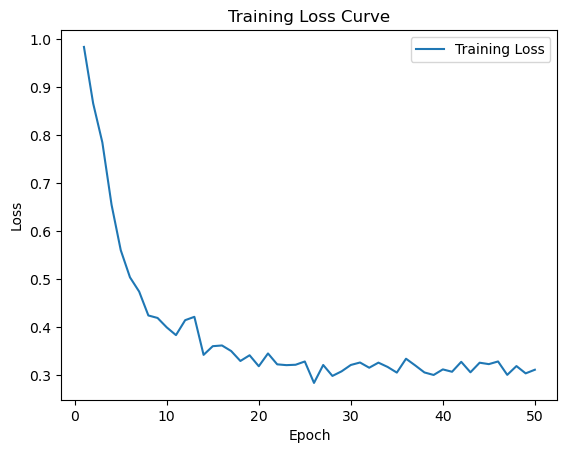

In [6]:
plot_loss(EPOCHS,mwcnn_validation_loss_record)

In [14]:
# make gan and train
gc.collect()
torch.cuda.empty_cache()
torch.cuda.set_per_process_memory_fraction(0.9999, 0)

In [4]:
mwcnn_discriminator = Discriminator(n_feats=64, patch_size=IMAGESIZE).to(device)
VGG_loss = VGGPerceptualLoss(resize=False).to(device)
mwcnn_gan_trainer = gan_trainer(MWCNN_model, mwcnn_discriminator, local_criterion=torch.nn.L1Loss(), global_criterion=VGG_loss, device=device)

mwcnn_gan_loss_record, mwcnn_gan_validation_loss_record = mwcnn_gan_trainer.train(EPOCHS, trainloader, validationloader)
torch.save(MWCNN_trainer, "../models/gan_mwcnn.pth")

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Training Process


/home/jurri/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 001,  G Loss:3.1983733, D Loss:5.5610082, 


KeyboardInterrupt: 

## Show prediction results per model

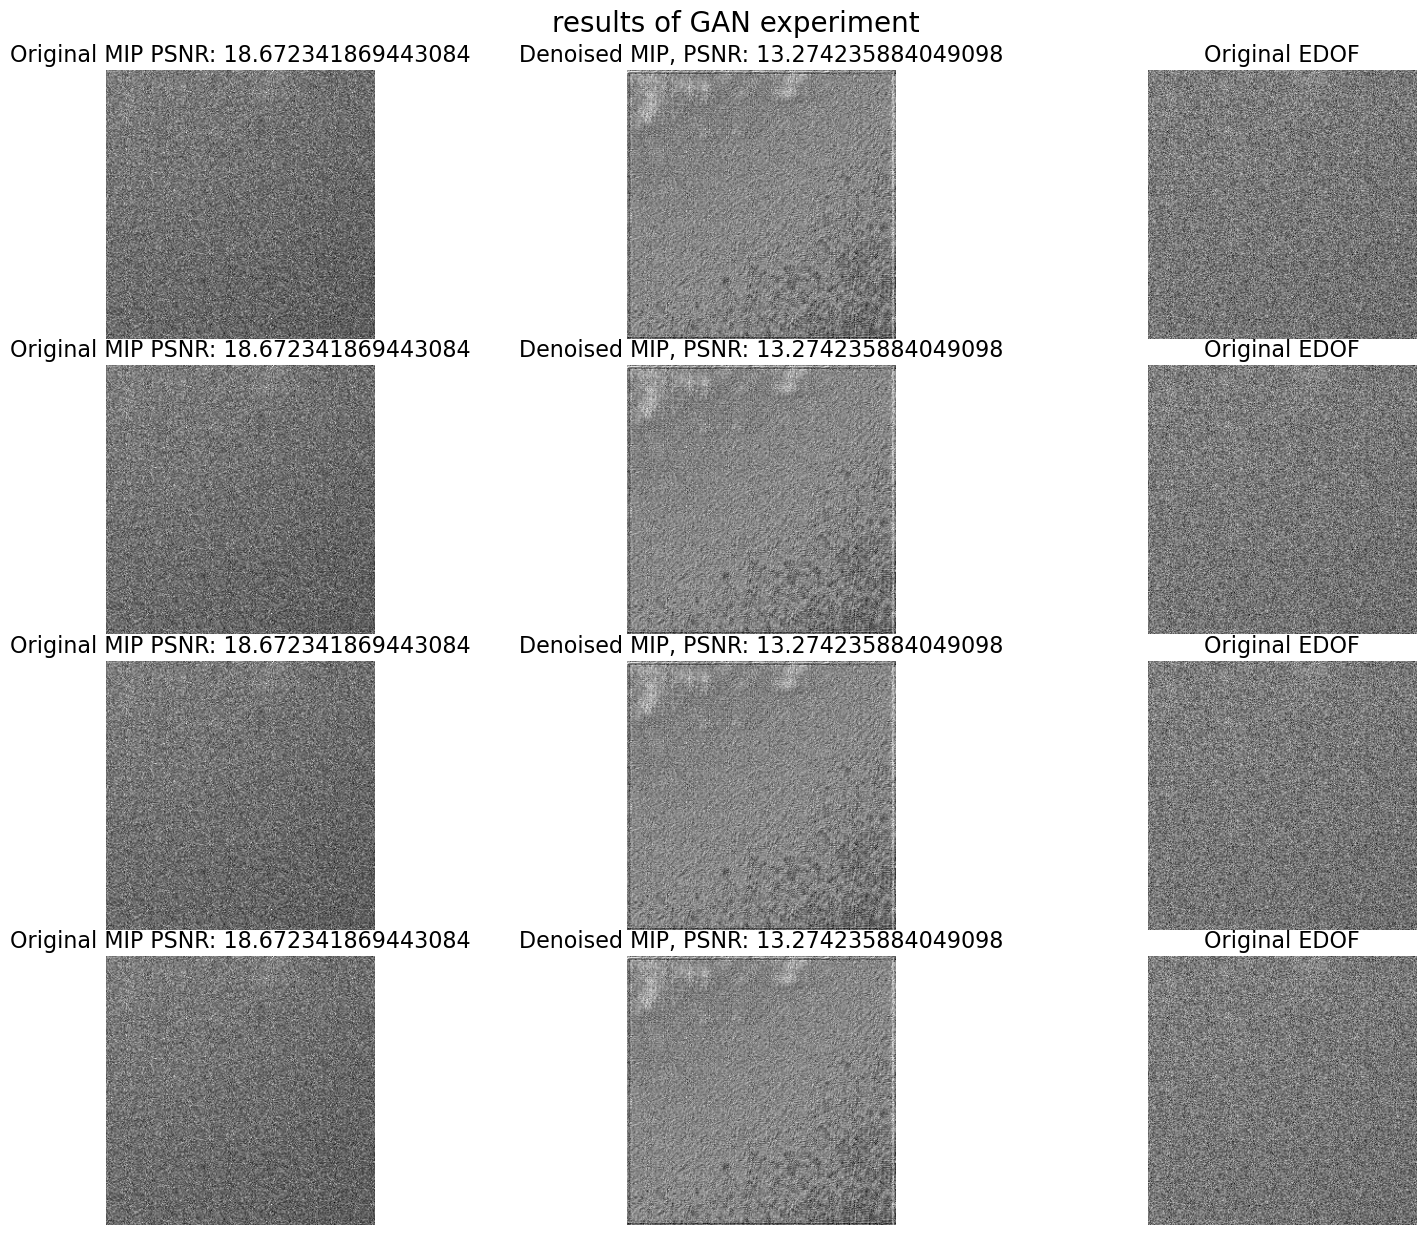

In [14]:
basic_mwcnn = MWCNN_model #torch.load("../models/mwcnn.pth")
gan_mwcnn = MWCNN_model
basic_unet = MWCNN_model #torch.load(MODEL_NAME)
gan_unet = MWCNN_model


models = [basic_mwcnn, gan_mwcnn, basic_unet, gan_unet]
model_names = ["basic_mwcnn", "gan_mwcnn", "basic_unet", "gan_unet"]
results = []
sample = test_image_dataset[0]
sharp = sample['output_image'].cpu().numpy().squeeze()
for model,name in zip(models, model_names):
    
    noisy = sample['input_image'][None,:,:,:].to(device)
    output = model(noisy)
    output = output.cpu().detach().numpy().squeeze()
    noisy = noisy.cpu().detach().numpy().squeeze()

    output_psnr = psnr(output, sharp)
    nosiy_psnr = psnr(noisy, sharp)
    
    results.append({
        "MIP": noisy,
        "pred": output,
        "EDOF": sharp,
        "original_score": nosiy_psnr,
        "improved_score": output_psnr,
        "model": name
    })

plot_result(results, "results of GAN experiment", save_path=None)

In [15]:
# MWCNN GAN
mwcnn_generator = MWCNN_model
discriminator = Discriminator(n_feats=64, patch_size=IMAGESIZE).to(device)
discriminator.train()

d_optim = optim.Adam(discriminator.parameters(), lr = 1e-4)
g_optim = optim.Adam(mwcnn_generator.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.StepLR(g_optim, step_size = 2000, gamma = 0.1)

VGG_loss = VGGPerceptualLoss(resize=False).to(device)
cross_ent = torch.nn.BCELoss()
L1_loss_func = torch.nn.L1Loss()

for epoch in range(EPOCHS):
    
    for i, data in enumerate(trainloader):
        # Loading data to device used.
        noisy = data['input_image'].to(device)
        sharp = data['output_image'].float().to(device)
                    
        ## Training Discriminator
        output = mwcnn_generator(noisy)
        real_prob = discriminator(sharp)
        fake_prob = discriminator(output)
        
        real_label = torch.ones_like(real_prob).to(device)
        fake_label = torch.zeros_like(fake_prob).to(device)

        d_loss_real = cross_ent(real_prob, real_label)
        d_loss_fake = cross_ent(fake_prob, fake_label)
        
        d_loss = d_loss_real + d_loss_fake

        g_optim.zero_grad()
        d_optim.zero_grad()
        d_loss.backward()
        d_optim.step()
        
        ## Training Generator
        output = mwcnn_generator(noisy)
        fake_prob = discriminator(output)
        
        # Do scaling of images, otherwise VGG_loss gives 0.0
        percep_loss = VGG_loss((sharp + 1.0) / 2.0, (output + 1.0) / 2.0)
        L1_loss = L1_loss_func(output, sharp)
        adversarial_loss = cross_ent(fake_prob, real_label)
        # L1 loss ~1 order of magnitude smaller
        g_loss = percep_loss + adversarial_loss + 10 * L1_loss
        
        g_optim.zero_grad()
        d_optim.zero_grad()
        g_loss.backward()
        g_optim.step()

        scheduler.step()

    # empty cache after each epoch
    gc.collect()
    torch.cuda.empty_cache()
        
    if epoch % 2 == 0:
        print(epoch)
        print(g_loss.item())
        print(d_loss.item())
        print('=========')


MODEL_NAME = f"../models/MWCNN_GAN_trained.pth"
torch.save(mwcnn_generator, MODEL_NAME)

0
5.457484722137451
1.3040988445281982


KeyboardInterrupt: 

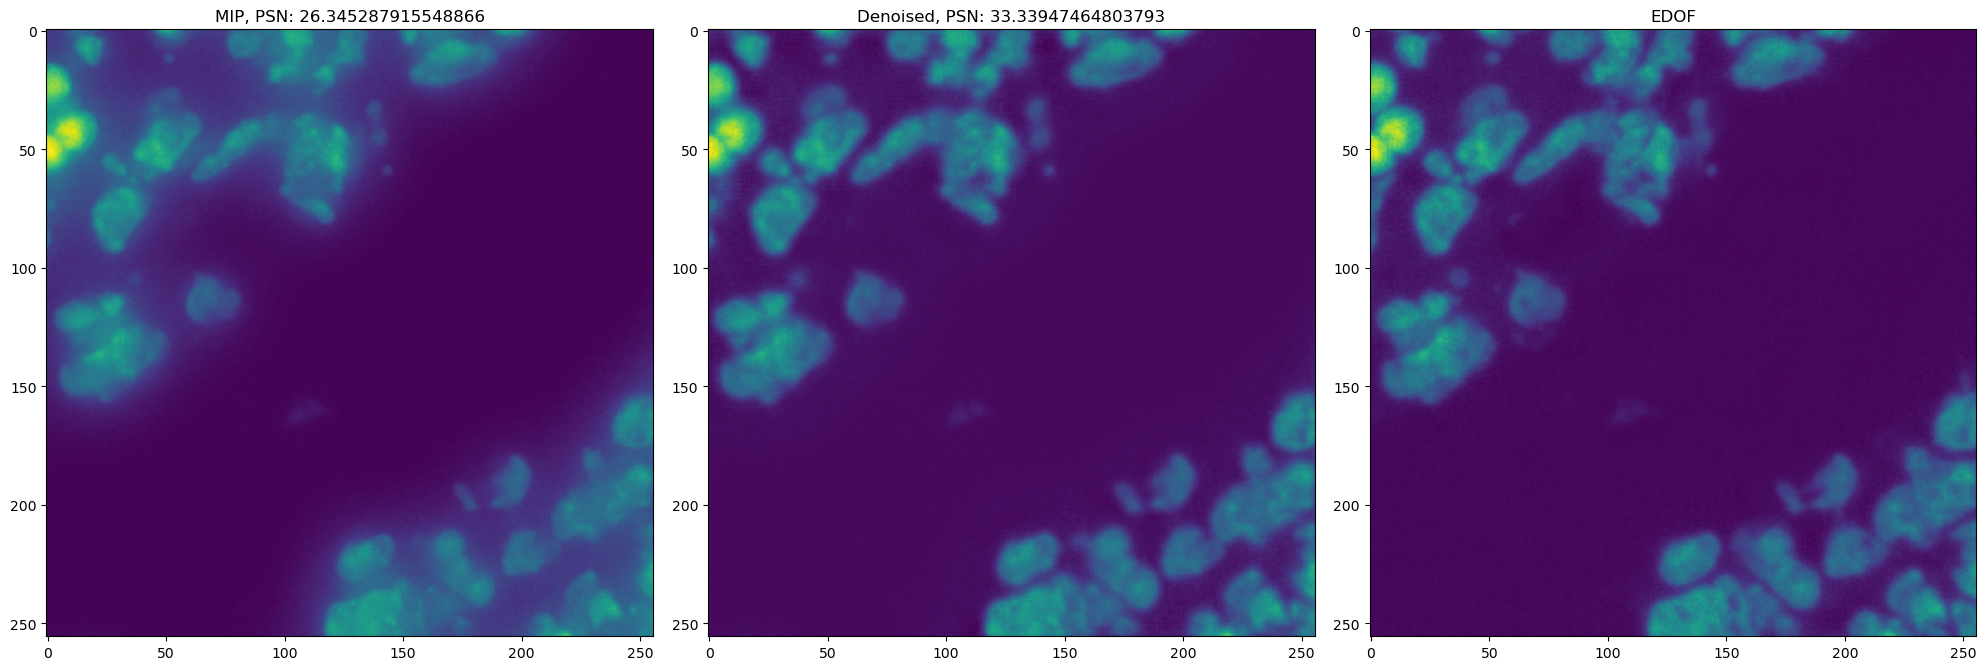

In [20]:
# show results
mwcnn_generator.eval()

for data in testloader:
    noisy = data['input_image'].to(device)
    sharp = data['output_image'].cpu().numpy().squeeze()
    output = mwcnn_generator(noisy)
    output = output.cpu().detach().numpy().squeeze()
    #output = (output + 1.0) / 2.0
    noisy = noisy.cpu().detach().numpy().squeeze()

    output_psnr = psnr(output, sharp)
    nosiy_psnr = psnr(noisy, sharp)
    break

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 60))
image_index = 0
sample = image_dataset[image_index]

ax[0].imshow(noisy.squeeze(), aspect='equal')
ax[0].set_title(f"MIP, PSN: {nosiy_psnr}")
ax[1].imshow(output.squeeze(), aspect='equal')
ax[1].set_title(f"Denoised, PSN: {output_psnr}")
ax[2].imshow(sharp.squeeze(), aspect='equal')
ax[2].set_title(f"EDOF")

plt.tight_layout()
plt.show()